# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
import math

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_model_simple, get_model_bhm, get_model_bhm_nc, get_model_logres, get_model_logres_nc

## Load data

Load previously generated data + clustering information (stored in an Analysis object).

In [5]:
# analysis_name = 'clustering'
# stage = 1

# analysis = load_obj('%s_%d.p' % (analysis_name, stage))
# analysis

In [6]:
# cd = analysis.clustering_data
# cd.responses.shape, cd.classes.shape, cd.features.shape, cd.clusters.shape

In [7]:
# df = cd.to_df()
# df.head()

In [8]:
# df.shape

In [9]:
# classes = df['class'].unique()
# classes

In [10]:
# ns = []
# ks = []
# for cls in classes:
#     observed = df[df['class'] == cls]['response'].values
#     n = len(observed)
#     k = np.sum(observed)
#     ns.append(n)
#     ks.append(k)
#     print(cls, observed, n, k)
    
# ns = np.array(ns)
# ks = np.array(ks)
# ns, ks

## Generate some data

In [11]:
# true params
α_true = [0, 0, -1, -1, 1, 1]
β_true = np.array([-3, 0.1, 3])

data = np.array([
    [0.30, 0.00, 0.33],
    [0.00, 0.00, 0.33],
    [0.00, 0.25, 0.00],
    [0.50, 0.25, 0.00],
    [0.00, 0.25, 0.33],
    [0.20, 0.25, 0.00]    
])

# Linear model
s_k0 = data[:, 0]
s_k1 = data[:, 1]
s_k2 = data[:, 2]
p_true = α_true + (β_true[0] * s_k0) + (β_true[1] * s_k1) + (β_true[2] * s_k2)
θ_true = logistic(p_true)

# Sample data
n = 100
n_success = np.random.binomial(n=n, p=θ_true)
n_trial = np.array([n] * len(n_success))

# Bundle data into dataframe
data_df = pd.DataFrame({'s_k0': s_k0, 's_k1': s_k1, 's_k2': s_k2, 'n_success': n_success, 'n_trial': n_trial})

In [12]:
n_success, n_trial, p_true, θ_true

(array([56, 69, 24,  5, 90, 65]),
 array([100, 100, 100, 100, 100, 100]),
 array([ 0.09 ,  0.99 , -0.975, -2.475,  2.015,  0.425]),
 array([0.52248482, 0.72908792, 0.27388502, 0.07762946, 0.88236301,
        0.60467908]))

In [13]:
data_df

,s_k0,s_k1,s_k2,n_success,n_trial
0,0.3,0.00,0.33,56,100
1,0.0,0.00,0.33,69,100
2,0.0,0.25,0.00,24,100
3,0.5,0.25,0.00,5,100
4,0.0,0.25,0.33,90,100
5,0.2,0.25,0.00,65,100


## Define models

No. of samples to collect before and after burn-in during MCMC.

In [14]:
# n_burn_in = int(5E3)
# n_sample = int(5E3)
# target_accept = 0.99

In [15]:
n_burn_in = int(1E3)
n_sample = int(1E3)
target_accept = 0.99

### Simple Beta-Binomial model

This is the standard simple hierarchical model typically used to infer basket success rate given the observed number of successes. It doesn't take into consideration the clustering information used to generate the data.

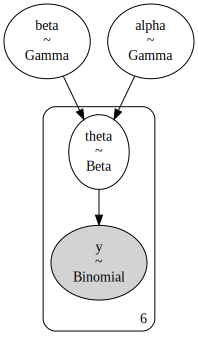

In [16]:
model_simple = get_model_simple(data_df)
pm.model_to_graphviz(model_simple)

In [17]:
with model_simple:
    trace_simple = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


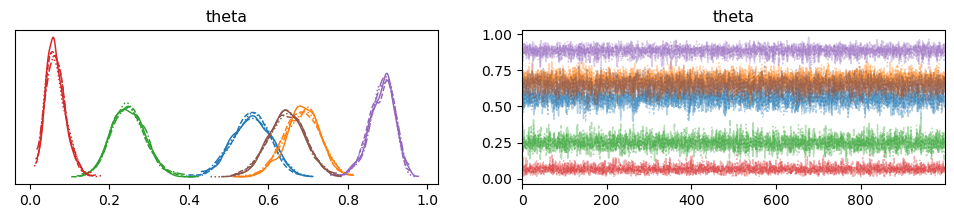

In [18]:
az.plot_trace(trace_simple, var_names=['theta']);

In [19]:
stacked_simple = az.extract(trace_simple)

(array([0.52248482, 0.72908792, 0.27388502, 0.07762946, 0.88236301,
        0.60467908]),
 array([0.55752385, 0.68439291, 0.24788334, 0.06549214, 0.88486607,
        0.64552695]),
 0.030885790010500416)

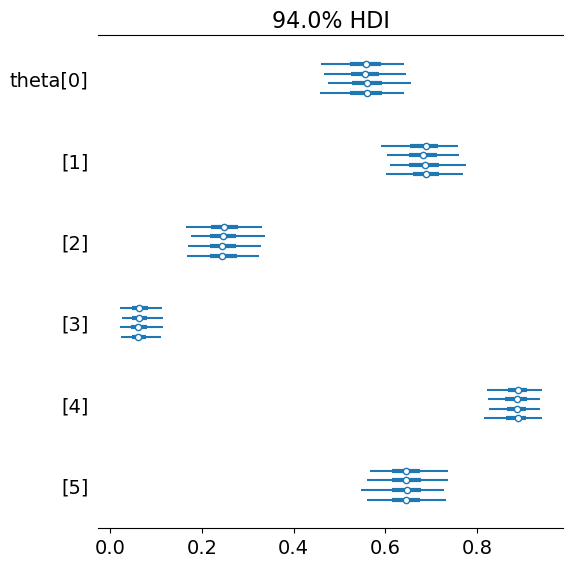

In [20]:
az.plot_forest(trace_simple, var_names='theta')

actual = θ_true
predicted = np.mean(stacked_simple.theta.values, axis=1)
actual, predicted, math.sqrt(mean_squared_error(actual, predicted))

### BHM

Here we model the log-odds rather than the probability value directly. Same as [Berry (2018)](https://onlinelibrary.wiley.com/doi/full/10.1002/bimj.201700162?casa_token=hlSHXWxCOSYAAAAA%3AeOrJBWA5kktlv8hweO8-JQ_hCZ2xg95-sCTum31bELz1SF-kwQfjPkkUq49AObbw8Oz4cGvdSYKeoKA).

### Centered Model

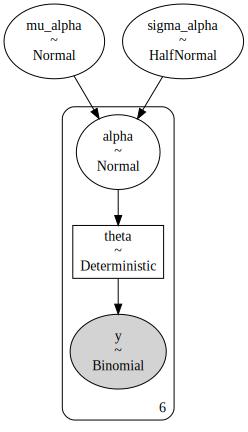

In [21]:
model_bhm = get_model_bhm(data_df)
pm.model_to_graphviz(model_bhm)

### Non-centered Model

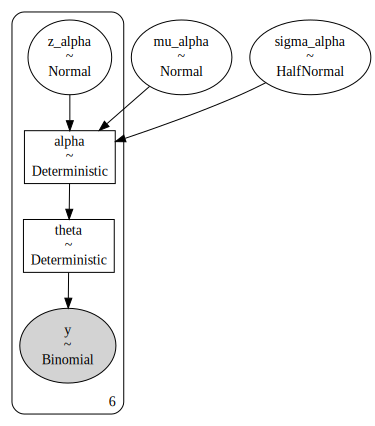

In [22]:
model_bhm_nc = get_model_bhm_nc(data_df)
pm.model_to_graphviz(model_bhm_nc)

In [23]:
with model_bhm_nc:
    trace_bhm_nc = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_alpha, mu_alpha, sigma_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


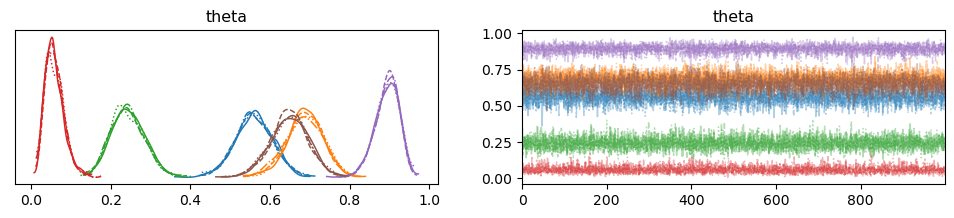

In [24]:
az.plot_trace(trace_bhm_nc, var_names=['theta']);

In [25]:
stacked_bhm_nc = az.extract(trace_bhm_nc)

([0, 0, -1, -1, 1, 1],
 array([ 0.24290564,  0.79493252, -1.15186348, -2.85600506,  2.17187893,
         0.62042455]),
 0.9726352446110625)

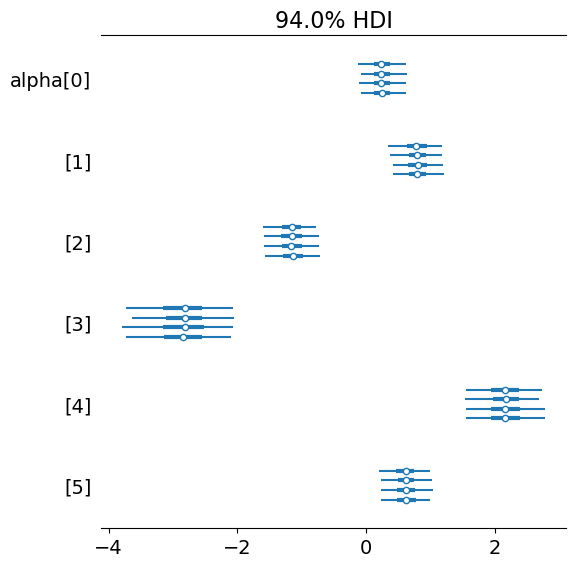

In [26]:
az.plot_forest(trace_bhm_nc, var_names='alpha')

actual = α_true
predicted = np.mean(stacked_bhm_nc.alpha.values, axis=1)
actual, predicted, math.sqrt(mean_squared_error(actual, predicted))

(array([0.52248482, 0.72908792, 0.27388502, 0.07762946, 0.88236301,
        0.60467908]),
 array([0.55988103, 0.68701705, 0.24263054, 0.05883956, 0.89390035,
        0.64881253]),
 0.03311396515691415)

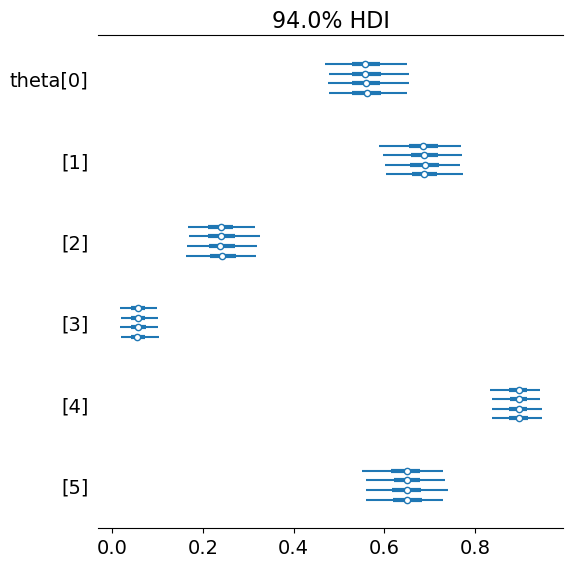

In [27]:
az.plot_forest(trace_bhm_nc, var_names='theta')

actual = θ_true
predicted = np.mean(stacked_bhm_nc.theta.values, axis=1)
actual, predicted, math.sqrt(mean_squared_error(actual, predicted))

### Logistic regression model

#### Centered model

This is a logistic regression model to predict response rate given the proportions of cluster members found in each basket, with additional hyper-priors on the parameters. Each basket k also has its own intercept term α_k. This model suffers from divergence problem during sampling.

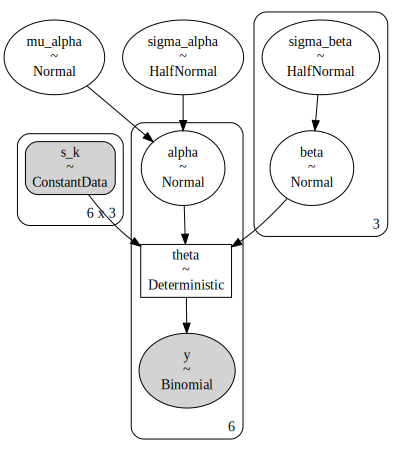

In [28]:
model_logres = get_model_logres(data_df)
pm.model_to_graphviz(model_logres)

### Non-centered Model

Non-centered model should sample better

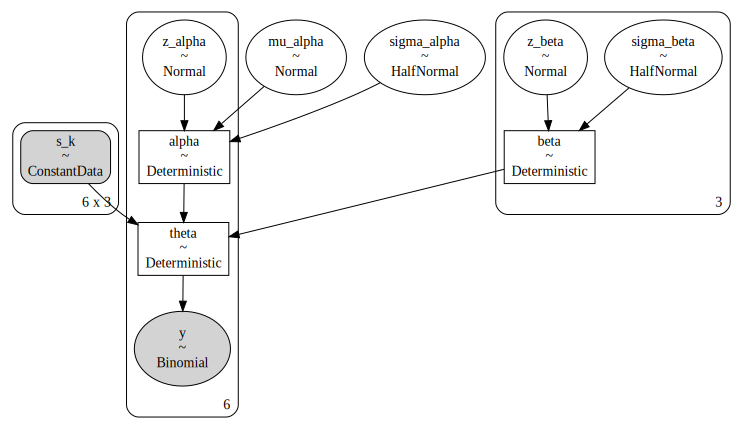

In [29]:
model_logres_nc = get_model_logres_nc(data_df)
pm.model_to_graphviz(model_logres_nc)

In [30]:
with model_logres_nc:
    trace_logres_nc = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_alpha, z_beta, mu_alpha, sigma_alpha, sigma_beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.


In [31]:
az.summary(trace_logres_nc).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_alpha[0],0.08,0.68,-1.26,1.28,0.02,0.01,2096.0,2077.0,1.0
z_alpha[1],-0.10,0.68,-1.42,1.09,0.02,0.01,1825.0,2216.0,1.0
z_alpha[2],-0.60,0.72,-2.04,0.68,0.02,0.01,1841.0,2416.0,1.0
z_alpha[3],-0.78,0.78,-2.23,0.73,0.02,0.01,2319.0,2489.0,1.0
z_alpha[4],0.64,0.73,-0.70,2.06,0.02,0.01,2138.0,2345.0,1.0
z_alpha[5],0.80,0.69,-0.43,2.09,0.02,0.01,1545.0,2176.0,1.0
z_beta[0],-0.45,0.70,-1.78,1.01,0.02,0.01,2089.0,1889.0,1.0
z_beta[1],0.04,0.85,-1.47,1.71,0.02,0.01,2117.0,2249.0,1.0
z_beta[2],0.47,0.77,-1.20,1.81,0.02,0.01,1907.0,1921.0,1.0
mu_alpha,-0.21,1.80,-3.51,3.40,0.05,0.03,1474.0,1921.0,1.0


array([[<AxesSubplot: title={'center': 'theta\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'theta\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'theta\n2'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'theta\n3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'theta\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'theta\n5'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)

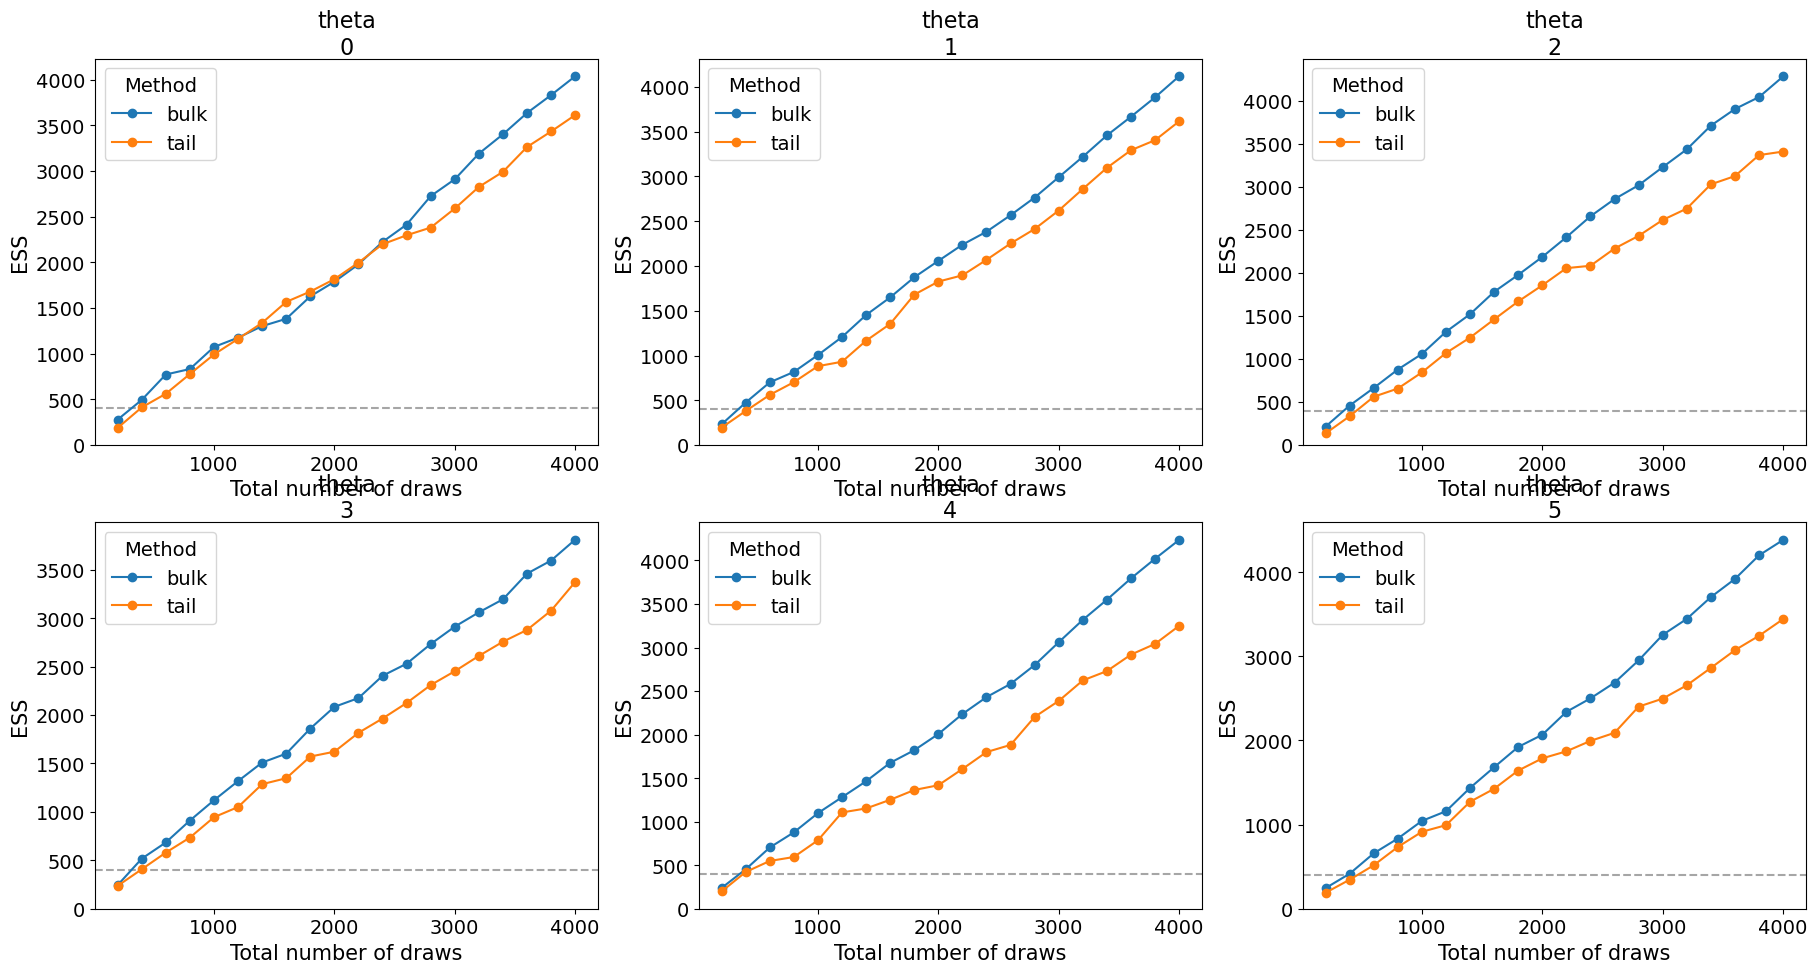

In [32]:
az.plot_ess(
    trace_logres_nc, kind="evolution", var_names=['theta']
)

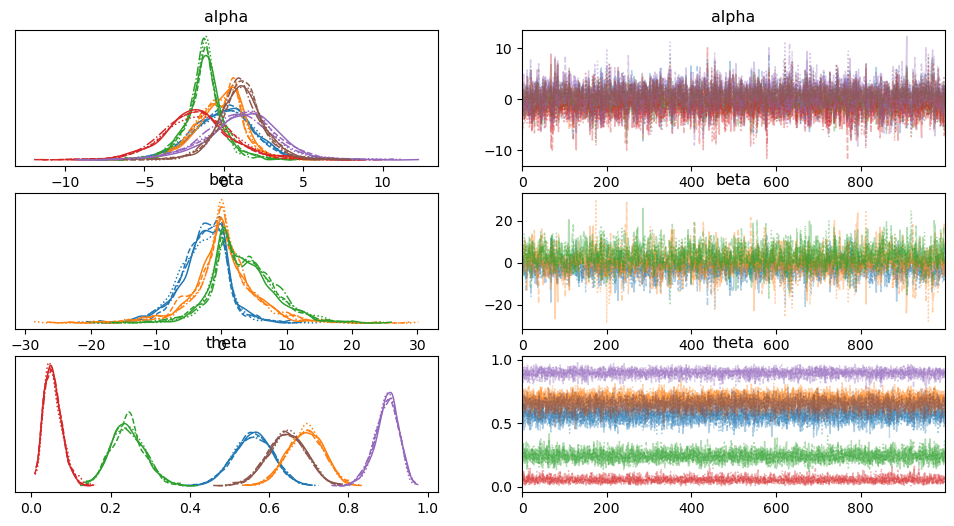

In [33]:
az.plot_trace(trace_logres_nc, var_names=['alpha', 'beta', 'theta']);

In [34]:
stacked_logres_nc = az.extract(trace_logres_nc)

([0, 0, -1, -1, 1, 1],
 array([-0.03178515, -0.27604762, -1.21747405, -1.63686737,  1.0304384 ,
         1.07649956]),
 0.2991338268479925)

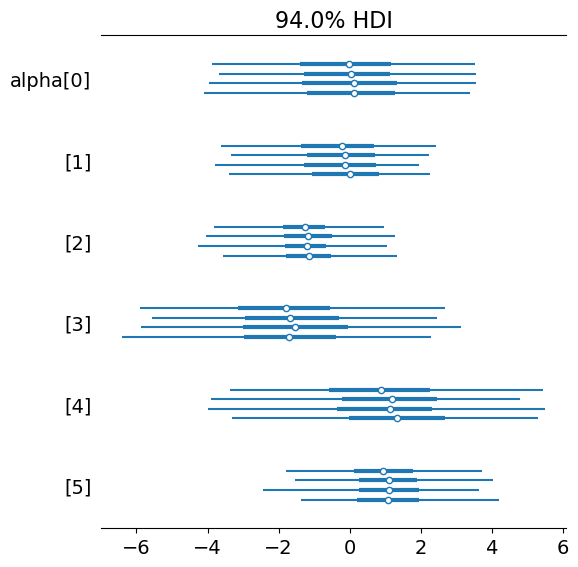

In [35]:
az.plot_forest(trace_logres_nc, var_names='alpha')

actual = α_true
predicted = np.mean(stacked_logres_nc.alpha.values, axis=1)
actual, predicted, math.sqrt(mean_squared_error(actual, predicted))

(array([-3. ,  0.1,  3. ]),
 array([-2.72608757,  0.28863753,  3.30821767]),
 0.2617952588136364)

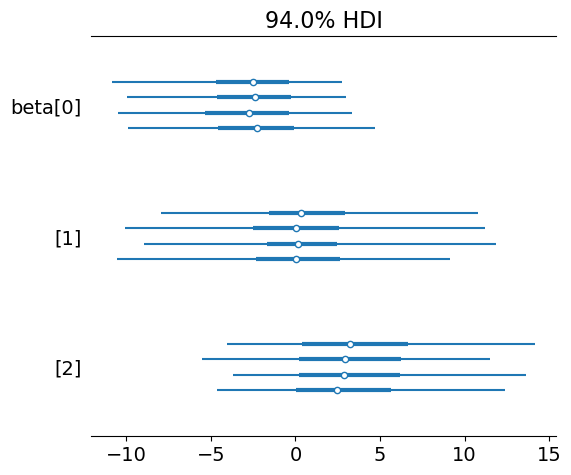

In [36]:
az.plot_forest(trace_logres_nc, var_names='beta')

actual = β_true
predicted = np.mean(stacked_logres_nc.beta.values, axis=1)
actual, predicted, math.sqrt(mean_squared_error(actual, predicted))

(array([0.52248482, 0.72908792, 0.27388502, 0.07762946, 0.88236301,
        0.60467908]),
 array([0.55964737, 0.69146302, 0.24384958, 0.05526898, 0.89589872,
        0.64494733]),
 0.03163213985754335)

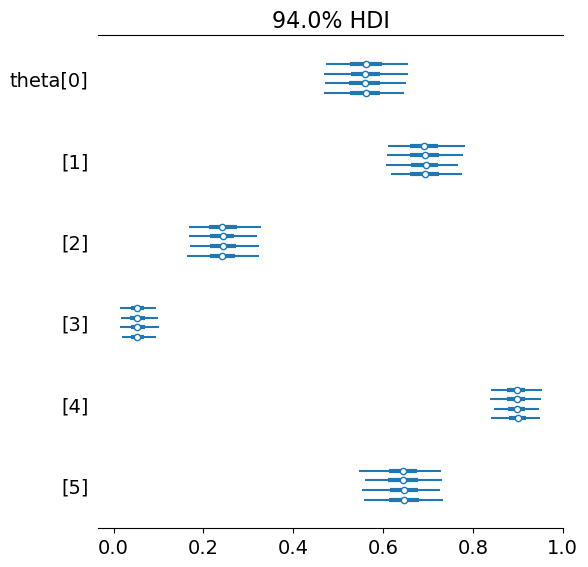

In [37]:
az.plot_forest(trace_logres_nc, var_names='theta')

actual = θ_true
predicted = np.mean(stacked_logres_nc.theta.values, axis=1)
actual, predicted, math.sqrt(mean_squared_error(actual, predicted))

### RMSE

In [38]:
actual = θ_true

predicted = np.mean(stacked_simple.theta.values, axis=1)
rmse_simple = math.sqrt(mean_squared_error(actual, predicted))

predicted = np.mean(stacked_bhm_nc.theta.values, axis=1)
rmse_bhm = math.sqrt(mean_squared_error(actual, predicted))

predicted = np.mean(stacked_logres_nc.theta.values, axis=1)
rmse_logres = math.sqrt(mean_squared_error(actual, predicted))

rmse_simple, rmse_bhm, rmse_logres

(0.030885790010500416, 0.03311396515691415, 0.03163213985754335)

### Model comparison

Model comparison using Leave-one-out Cross-validation ([LOO](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html))

> LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples (without the need for re-fitting the data). This approximation is based on importance sampling. The importance weights are stabilized using a method known as Pareto-smoothed importance sampling (PSIS).

In [39]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [40]:
loo_simple = az.loo(trace_simple)
loo_simple

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 6 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -21.19     0.26
p_loo        5.46        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         4   66.7%
   (1, Inf)   (very bad)    2   33.3%

In [41]:
loo_bhm_nc = az.loo(trace_bhm_nc)
loo_bhm_nc

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 6 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -20.38     0.50
p_loo        4.76        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          1   16.7%
   (0.7, 1]   (bad)         5   83.3%
   (1, Inf)   (very bad)    0    0.0%

In [42]:
loo_logres_nc = az.loo(trace_logres_nc)
loo_logres_nc

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 6 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -20.02     0.80
p_loo        4.37        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          1   16.7%
   (0.7, 1]   (bad)         5   83.3%
   (1, Inf)   (very bad)    0    0.0%

In [43]:
ic = 'loo'
df_comp_loo = az.compare({
    'simple': trace_simple, 
    'bhm': trace_bhm_nc,
    'logres': loo_logres_nc,
}, ic=ic)
df_comp_loo

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
logres,0,-20.022535,4.373213,0.000000,1.000000e+00,0.802388,0.000000,True,log
bhm,1,-20.376087,4.755060,0.353551,3.885781e-16,0.495676,0.394269,True,log
simple,2,-21.189468,5.457071,1.166933,0.000000e+00,0.259703,0.815364,True,log


Compare models based on their expected log pointwise predictive density ([ELPD](https://python.arviz.org/en/latest/api/generated/arviz.compare.html)).

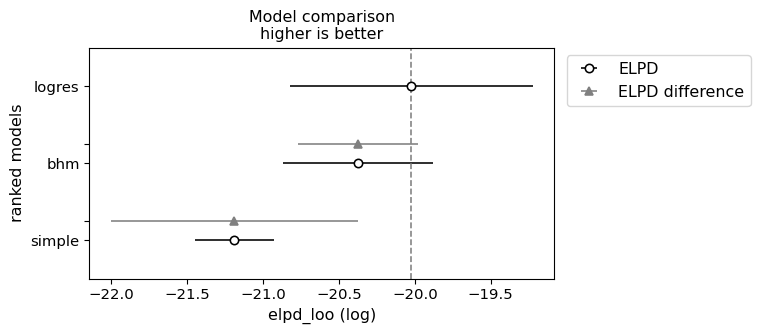

In [44]:
az.plot_compare(df_comp_loo);